In [1]:
from __future__ import annotations   
import math                           
from typing import Callable, Dict, Optional, Tuple, Union  

import numpy as np                    
import pandas as pd                   
import torch                          
import torch.nn as nn                 
import matplotlib.pyplot as plt       

# ===== PINN funcional: defs only (no execution here) =====
# ---------- construção da rede ----------
def build_mlp(in_dim: int = 1, out_dim: int = 1, width: int = 64, depth: int = 4) -> nn.Module:
    """Builds a fully-connected MLP with Tanh activations."""
    layers = [nn.Linear(in_dim, width), nn.Tanh()]           # First layer: input -> hidden
    for _ in range(depth - 1):                               # Add (depth-1) hidden layers
        layers += [nn.Linear(width, width), nn.Tanh()]       # Each with width neurons + Tanh activation
    layers += [nn.Linear(width, out_dim)]                    # Output layer: hidden -> output
    return nn.Sequential(*layers)                            # Sequential container

# ---------- autograd ----------
# --- Derivadas robustas (garante leaf + grad habilitado) ---
def time_derivatives(model: torch.nn.Module, t: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Computes y, dy/dt, and d²y/dt² for the given model and time tensor."""
    # Ensure t is a leaf tensor with grad enabled
    t = t.detach().clone().requires_grad_(True)    
    # Force autograd on (in case it was disabled globally)
    with torch.enable_grad(): 
        # Forward pass through the model
        y = model(t)            
        # Safety check
        assert y.requires_grad, "model(t) não tem grad_fn (autograd foi desativado em algum lugar)."  
        (y_t,)  = torch.autograd.grad(                       # First derivative dy/dt
            y, t, torch.ones_like(y), create_graph=True, retain_graph=True
        )
        (y_tt,) = torch.autograd.grad(                       # Second derivative d²y/dt²
            y_t, t, torch.ones_like(y_t), create_graph=True, retain_graph=True
        )
    return {"y": y.squeeze(1), "y_t": y_t.squeeze(1), "y_tt": y_tt.squeeze(1)}  # Return dict with flattened outputs

# ---------- grid de tempo ----------
def make_time_grid(t_spec: Union[Tuple[float, float, int], ArrayLike], device: Optional[torch.device] = None) -> Tensor:
    """Creates a [N,1] time tensor from a tuple (t0, t1, N) or an array/tensor."""
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Default to GPU if available
    if isinstance(t_spec, tuple) and len(t_spec) == 3:
        t0, t1, n = t_spec
        return torch.linspace(float(t0), float(t1), int(n), device=device).reshape(-1, 1)  # Uniform grid
    if isinstance(t_spec, torch.Tensor):
        return t_spec.to(device).reshape(-1, 1)                                         # Convert tensor to device
    return torch.as_tensor(t_spec, dtype=torch.float32, device=device).reshape(-1, 1)   # Convert array-like to tensor

# ---------- perdas ----------
def pinn_losses(
    model: nn.Module,
    t_f: Tensor,   # Collocation points for physics residual
    t_ic: Tensor,  # Initial condition points
    residual_fn: Callable[[Dict[str, Tensor], Tensor], Tensor],  # Function computing residual of governing equation
    ic: Tuple[float, float]  # Initial conditions (y0, ydot0)
) -> Tuple[Tensor, Dict[str, float]]:
    """Returns (total_loss, metrics_dict) for the PINN."""
    # Physics loss
    obs_f = time_derivatives(model, t_f)                 # y, y_t, y_tt at collocation points
    res = residual_fn(obs_f, t_f).squeeze()              # Residual of the equation
    loss_phys = (res**2).mean()                          # MSE of residuals

    # Initial condition loss
    obs_ic = time_derivatives(model, t_ic)               # y, y_t at IC point(s)
    y0, ydot0 = ic
    loss_ic = (obs_ic["y"] - y0).pow(2).mean() + (obs_ic["y_t"] - ydot0).pow(2).mean()  # MSE on ICs

    # Total loss
    loss = loss_phys + loss_ic
    metrics = {"phys": float(loss_phys.detach().cpu()), "ic": float(loss_ic.detach().cpu())}  # Detached metrics for logging
    return loss, metrics

# ---------- treino ----------
def train_pinn(
    model: nn.Module,
    residual_fn: Callable[[Dict[str, Tensor], Tensor], Tensor],  # Physics residual function
    ic: Tuple[float, float],                                     # Initial conditions
    T_final: float = 6.0,                                        # Time domain end
    N_f: int = 2000,                                             # Number of collocation points
    epochs: int = 6000,                                          # Adam epochs
    lr: float = 1e-3,                                            # Adam learning rate
    seed: int = 0,                                               # Random seed
    device: Optional[torch.device] = None,
    use_lbfgs: bool = True                                       # Whether to use LBFGS refinement
) -> nn.Module:
    """Trains a PINN with Adam + optional LBFGS."""
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(seed)
    model.to(device).train()

    # Collocation points and IC points
    t_f = torch.rand(N_f, 1, device=device) * T_final            # Uniformly random in (0, T_final)
    t_ic = torch.zeros(1, 1, device=device)                      # t=0

    # Adam optimization loop
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for e in range(epochs):
        opt.zero_grad()
        loss, m = pinn_losses(model, t_f, t_ic, residual_fn, ic)
        loss.backward()
        opt.step()
        if (e + 1) % 1000 == 0:
            print(f"[Adam] {e+1:4d} | loss={loss.item():.3e} | phys={m['phys']:.3e} | ic={m['ic']:.3e}")

    # LBFGS refinement
    if use_lbfgs:
        model.train()
        lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=500,
                                  tolerance_grad=1e-8, tolerance_change=1e-9,
                                  line_search_fn='strong_wolfe')
        def closure():
            lbfgs.zero_grad()
            loss, _ = pinn_losses(model, t_f, t_ic, residual_fn, ic)
            loss.backward()
            return loss
        lbfgs.step(closure)
        with torch.no_grad():
            loss, m = pinn_losses(model, t_f, t_ic, residual_fn, ic)
            print(f"[LBFGS] final | loss={loss.item():.3e} | phys={m['phys']:.3e} | ic={m['ic']:.3e}")

    return model

# --- DataFrame robusto (sem no_grad e com grad habilitado) ---
def pinn_to_dataframe(
    model: torch.nn.Module,
    t_spec: Union[Tuple[float, float, int], ArrayLike],
    *,
    observables_fn: Optional[Callable[[torch.nn.Module, torch.Tensor], Dict[str, torch.Tensor]]] = None,
    residual_fn: Optional[Callable[[Dict[str, torch.Tensor], torch.Tensor], torch.Tensor]] = None,
    extra_metrics_fn: Optional[Callable[[Dict[str, torch.Tensor], torch.Tensor], Dict[str, torch.Tensor]]] = None,
    device: Optional[torch.device] = None,
    eval_mode: bool = True
) -> pd.DataFrame:
    """Samples the model on a time grid and returns a DataFrame with observables, residuals, and extra metrics."""
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if eval_mode:
        model.eval()
    t = make_time_grid(t_spec, device)

    obs_fn = observables_fn or time_derivatives
    with torch.enable_grad():                 # Ensure autograd is active
        obs = obs_fn(model, t)                 # Compute y, y_t, y_tt
        if residual_fn is not None:
            obs["residual"] = residual_fn(obs, t)  # Physics residual
        if extra_metrics_fn is not None:
            obs.update(extra_metrics_fn(obs, t))   # Extra metrics

    # Detach all tensors and convert to NumPy
    out = {"t": t.squeeze(1).detach().cpu().numpy()}
    for k, v in obs.items():
        out[k] = v.detach().cpu().numpy()
    return pd.DataFrame(out)

# ---------- plot ----------
def plot_pinn_dataframe(
    df: pd.DataFrame,
    y_cols=("y", "y_t", "y_tt", "residual"),
    *,
    t_col="t",
    save_prefix: Optional[str] = None,
    dpi: int = 150
) -> None:
    """Plots each selected column vs. the time column."""
    if t_col not in df.columns:
        raise ValueError(f"'{t_col}' not in DataFrame.")
    t = df[t_col].values
    for name in y_cols:
        if name not in df.columns:
            continue
        y = df[name].values
        plt.figure()
        plt.plot(t, y)
        plt.xlabel(t_col); plt.ylabel(name); plt.title(f"{name} vs {t_col}")
        plt.grid(True); plt.tight_layout()
        if save_prefix is not None:
            plt.savefig(f"{save_prefix}_{name}.png", dpi=dpi)
    plt.show()

# ===== Exemplo: pêndulo não-linear (Newton) ===== 
# residual da física: theta'' + (g/L) sin(theta) = 0
def pendulum_residual(obs: Dict[str, torch.Tensor], t: Tensor) -> Tensor:
    """Physics residual for nonlinear pendulum."""
    return obs["y_tt"] + (g / L) * torch.sin(obs["y"])

# energia mecânica (opcional)
def pendulum_energy(obs: Dict[str, torch.Tensor], t: Tensor) -> Dict[str, torch.Tensor]:
    """Mechanical energy of the pendulum (kinetic + potential)."""
    E = 0.5 * (L**2) * obs["y_t"]**2 + g * L * (1.0 - torch.cos(obs["y"]))
    return {"energy": E}


In [2]:
Tensor = torch.Tensor
ArrayLike = Union[np.ndarray, Tensor]

# parâmetros
g, L = 9.81, 1.0
theta0, omega0 = 0.75, 0.0            # IC
T_final = 6.0

# construir rede
model = build_mlp(in_dim=1, out_dim=1, width=64, depth=4)

# treinar
model = train_pinn(
    model,
    residual_fn=pendulum_residual,
    ic=(theta0, omega0),
    T_final=T_final,
    N_f=2000,
    epochs=6000,
    lr=1e-3,
    seed=0,
    use_lbfgs=True,
)

# amostrar e gerar DataFrame
df = pinn_to_dataframe(
    model,
    t_spec=(0.0, T_final, 400),
    residual_fn=pendulum_residual,
    extra_metrics_fn=pendulum_energy,
)

df.head()

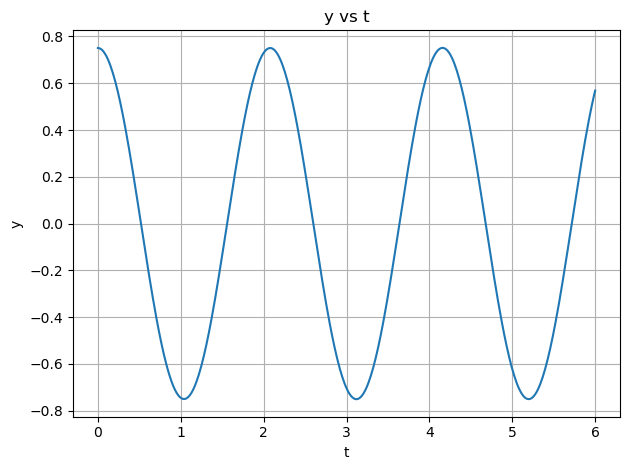

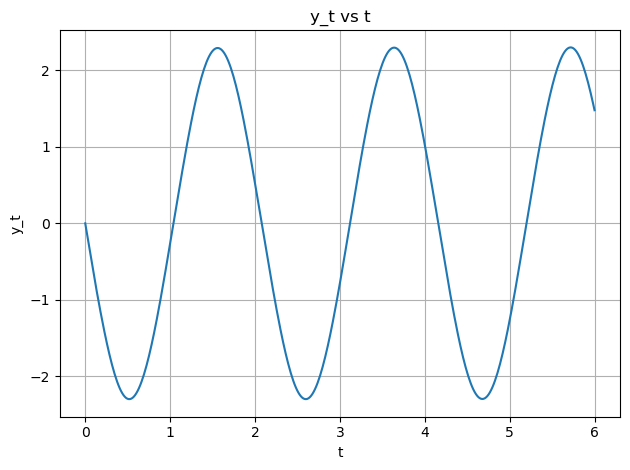

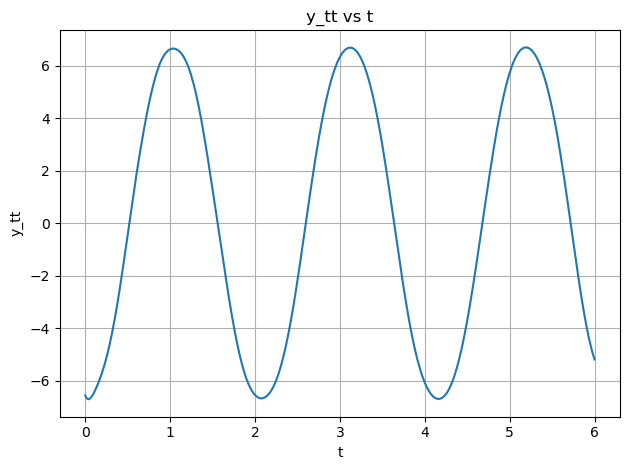

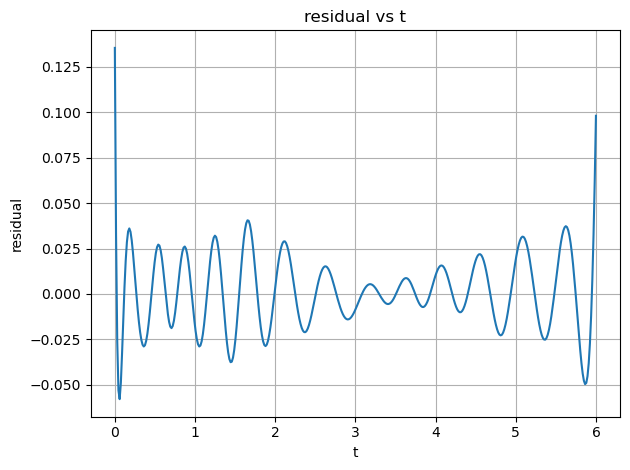

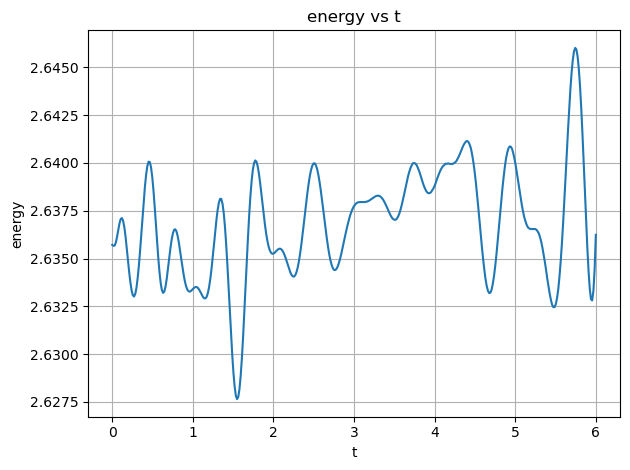

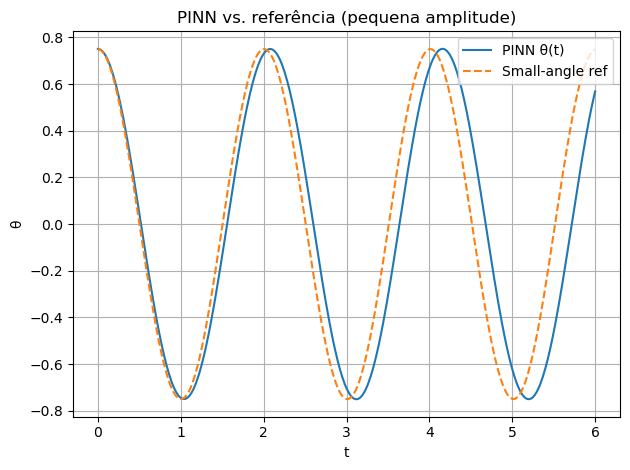

In [4]:
# plotar
plot_pinn_dataframe(df, y_cols=("y","y_t","y_tt","residual","energy"))

# comparação com aproximação de pequena amplitude (referência qualitativa)
t_vals = df["t"].values
omega = math.sqrt(g/L)
theta_lin = theta0 * np.cos(omega*t_vals) + (omega0/omega) * np.sin(omega*t_vals)

plt.figure()
plt.plot(t_vals, df["y"].values, label="PINN θ(t)")
plt.plot(t_vals, theta_lin, linestyle="--", label="Small-angle ref")
plt.xlabel("t"); plt.ylabel("θ"); plt.title("PINN vs. referência (pequena amplitude)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()